In [6]:
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mave_calibration.skew_normal import density_utils
from main import load_data
import numpy as np

/home/dz/research/mave_calibration/main.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
dataset_id = "urn_mavedb_00000013-a-1"
config_name = "missense_config"
N_bootstraps = 24

In [7]:
# observations = joblib.load(f"/mnt/d/mave_calibration/data/{dataset_id}/observations.pkl")
X,S,sample_names = load_data(data_directory = "/mnt/d/mave_calibration/data",dataset_id=dataset_id,config_name=config_name)
results = []
for bootstrap_iter in range(1, N_bootstraps+1):
    with open(f"/mnt/d/mave_calibration/results/bootstrap_iters/iter_{bootstrap_iter}/{config_name}/{dataset_id}/result.json") as f:
        result = json.load(f)
    results.append(result)

In [9]:
results[0].keys()

dict_keys(['component_params', 'weights', 'likelihoods', 'config'])

In [13]:
def plot(X, S, sample_names, current_weights, current_params):
    cmap = sns.color_palette("pastel", 3)
    N_samples = S.shape[1]
    fig,ax = plt.subplots(N_samples,1,figsize=(10,10),sharex=True,sharey=True)
    for sample_num in range(N_samples):
        sns.histplot(X[S[:,sample_num]], ax=ax[sample_num],color=cmap[sample_num] ,stat='density')
        ax[sample_num].spines['top'].set_visible(False)
        ax[sample_num].spines['right'].set_visible(False)
        ax[sample_num].spines['bottom'].set_visible(False)
        ax[sample_num].spines['left'].set_visible(False)
        ax[sample_num].set_ylabel("")
        ax[sample_num].set_yticks(())
        ax[sample_num].set_title(f"{sample_names[sample_num].replace('_',' ')} Variants".title())
    layer_distributions(X, S, current_weights, current_params, ax, label='estimated')
    return fig,ax

def layer_distributions(X, S, W, P, ax,label="",linestyle='-'):
    cmap = sns.color_palette("husl",3)
    N_samples = S.shape[1]
    N_components = len(P[0])
    rng = np.arange(X.min(), X.max(), .01)
    for sample_num in range(N_samples):
        component_joint_pdfs = np.stack([density_utils.joint_densities(rng, params_, weights_[sample_num]) for weights_,params_ in zip(W,P)],axis=1)
        for component_num in range(N_components):
            CC = component_joint_pdfs[component_num]
            y1,y2 = np.quantile(CC, [.025,.975],axis=0)
            ax[sample_num].fill_between(rng, y1,y2,
                label=f"Component {component_num} {label}",
                color=cmap[component_num],
                linestyle=linestyle,alpha=.5)
        mixture_pdf = component_joint_pdfs.sum(axis=0)
        y1,y2 = np.quantile(mixture_pdf, [.025,.975],axis=0)
        ax[sample_num].fill_between(rng, y1,y2, label=f"Mixture {label}",color=cmap[-1],linestyle=linestyle,alpha=.5)

(<Figure size 1000x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Pathogenic Missense Variants'}>,
        <Axes: title={'center': 'Synonymous Variants'}>,
        <Axes: title={'center': 'Missense Variants'}>], dtype=object))

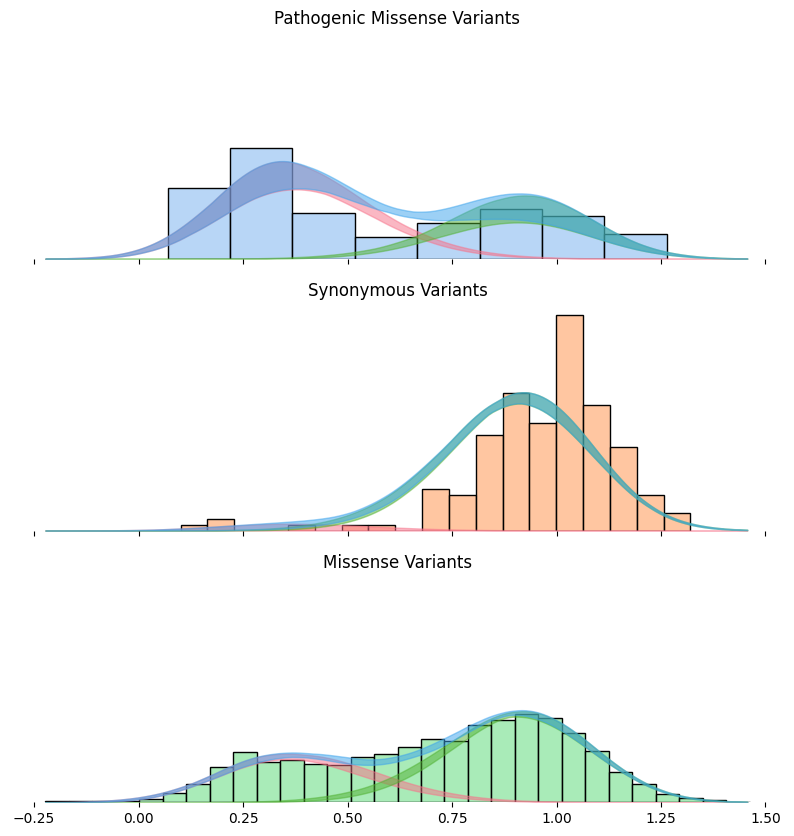

In [14]:
plot(X,S,sample_names,[r['weights'] for r in results], [r['component_params'] for r in results])